<a href="https://colab.research.google.com/github/sanjeevr5/NLP_Excercises/blob/main/DL_With_NLP_ULMFiT_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an LM With ULMFiT and then applying classification model on top of it

## Downloading dataset

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv

In [ ]:
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
from fastai.text.all import *

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Creating data for LM

<b> make sure is_lm is True </b>

In [ ]:
train = TextDataLoaders.from_csv('.', csv_fname = 'train.csv', header = None, delimiter =',', text_col = 2, label_col = 0, is_lm = True, device = device)
test = TextDataLoaders.from_csv('.', csv_fname = 'test.csv', header = None, delimiter =',', text_col = 2, label_col = 0, device = device)

In [ ]:
train.show_batch(max_n = 3)

,text,text_
0,"xxbos a rugby nation lifted its head once more last night . xxmaj the surprise was that it was xxmaj south xxmaj africa , not xxmaj australia or xxmaj new xxmaj zealand , who emerged into the light clutching the coveted tri - nations trophy . xxbos xxup new xxup york - xxmaj mitsubishi xxmaj motors xxmaj north xxmaj america xxmaj inc launched a television ad campaign on xxmaj monday to improve","a rugby nation lifted its head once more last night . xxmaj the surprise was that it was xxmaj south xxmaj africa , not xxmaj australia or xxmaj new xxmaj zealand , who emerged into the light clutching the coveted tri - nations trophy . xxbos xxup new xxup york - xxmaj mitsubishi xxmaj motors xxmaj north xxmaj america xxmaj inc launched a television ad campaign on xxmaj monday to improve its"
1,"explosive belts seemed to acknowledge his xxmaj al xxmaj qaeda membership . xxbos xxmaj solberg got off to an astonishing start , winning three of the opening four stages to charge into a 20 - second lead before losing a handful of seconds to xxmaj loeb on stages five and six . xxbos xxup beijing : xxmaj china 's central bank said it would take a ' gradual and safe ' approach","belts seemed to acknowledge his xxmaj al xxmaj qaeda membership . xxbos xxmaj solberg got off to an astonishing start , winning three of the opening four stages to charge into a 20 - second lead before losing a handful of seconds to xxmaj loeb on stages five and six . xxbos xxup beijing : xxmaj china 's central bank said it would take a ' gradual and safe ' approach to"
2,"1993 , xxmaj willie xxmaj randolph won ' t be in a xxmaj yankees uniform on xxmaj opening xxmaj day when xxmaj new xxmaj york opens its season next xxmaj april . xxbos xxunk - xxmaj by xxmaj xxunk ben - ivan xxmaj lee : xxmaj the boxing economy is a trickle - down economy in its basic nature . xxmaj wealth trickles down from the heavyweight division to the lower weights",", xxmaj willie xxmaj randolph won ' t be in a xxmaj yankees uniform on xxmaj opening xxmaj day when xxmaj new xxmaj york opens its season next xxmaj april . xxbos xxunk - xxmaj by xxmaj xxunk ben - ivan xxmaj lee : xxmaj the boxing economy is a trickle - down economy in its basic nature . xxmaj wealth trickles down from the heavyweight division to the lower weights ;"


**So what are these xx special words?**

1. **xxbos** represents the beginning of the sentence/stream
2. **xxunk** represents an unknown word that is not known by the LM
3. **xxmaj** represents that the next word has an upper case first character and has been made into a lower case character.
4. **xxrep** represents that the previous character was repeated 'n' times Eg. 1 xxrep 3 means 1 was repeated thrice.
5. **xxwrep** represents the replacement of any word that was repeated 'n' times and then the word
6. **xxcap** represents the replacement of the word from upper case to lower case
7. **xxeos** represents the end of stream/sentence

In [ ]:
lang_mod = language_model_learner(train,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

In [ ]:
for i in range(5):
  print(lang_mod.predict("India won the match", n_words=10))

India won the match between 1948 and 1952 = India = United


India won the match electrified every three weeks within a day . However


India won the match for India = wins after a missile controlled by


India won the match and achieved the championship the following year . After


India won the match for the United States at the Werner


<b> The word2index can be accessed using the lm_object.o2i </b>

In [ ]:
train.o2i['the']

9

In [ ]:
stoi = train.o2i
itos = {index:token for token, index in stoi.items()}

## Finding out most similar tokens using cosine similarity

In [ ]:
import torch.nn
from torch.nn import functional as F

def normalizeEmbeddings(weights):
  return F.normalize(weights)

nw = normalizeEmbeddings(lang_mod.model[0].encoder.weight)

def mostSimilar(data, token, embeds):
  idx = data.o2i[token]
  sim_vals = (embeds[idx] @ embeds.t()).cpu().detach().numpy()
  for sim_idx in np.argsort(sim_vals)[::-1][1:11]:
    print(f'{itos[sim_idx]:<30}{sim_vals[sim_idx]:.02f}')

mostSimilar(train, 'india', nw)

china                         0.57
pakistan                      0.51
japan                         0.50
egypt                         0.48
australia                     0.48
brazil                        0.47
asia                          0.47
germany                       0.47
europe                        0.44
burma                         0.44


## Finding the optimal learning rate

1. The learning rate chosen is not at the point where the loss is minimum. It is the point where the loss decreases very rapidly. (https://www.jeremyjordan.me/nn-learning-rate/)
2. https://sgugger.github.io/the-1cycle-policy.html

SuggestedLRs(valley=0.0030199517495930195)

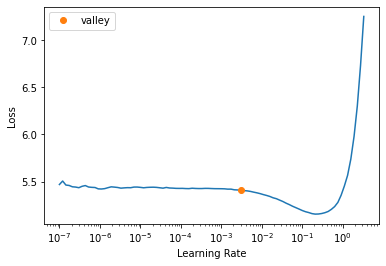

In [ ]:
lang_mod.freeze_to(-1) #unfreezing the 3rd stacked LSTM 
lang_mod.lr_find()

SuggestedLRs(valley=0.0014454397605732083)

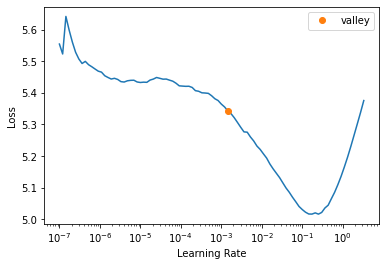

In [ ]:
lang_mod.freeze_to(-2) #unfreezing the 2nd stacked LSTM 
lang_mod.lr_find()

SuggestedLRs(valley=0.0006918309954926372)

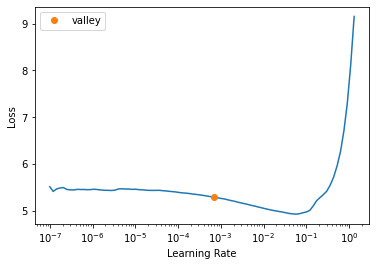

In [ ]:
lang_mod.unfreeze() #unfreezing everything
lang_mod.lr_find()

<b> Fitting the model with the 1 CYCLE POLICY

In [ ]:
lang_mod.fit_one_cycle(3, slice(3e-2, 6e-6)) #(n_layers, slicing) slice(-1, -n) higher learning rates for -1 than -n 

epoch,train_loss,valid_loss,time
0,4.229960,3.889369,07:42
1,3.990425,3.692484,07:43
2,3.852309,3.628312,07:42


In [ ]:
lang_mod.save_encoder('news_encoder')

## Training the classifier

In [ ]:
train_c = TextDataLoaders.from_csv('.', csv_fname = 'train.csv', header = None, delimiter =',', text_col = 2, label_col = 0,  device = device)

In [ ]:
train_c.show_batch(max_n = 3)

,text,category
0,"xxbos 4 xxmaj miami at xxup n.c . xxmaj state < xxunk p.m. , xxup espn < / em><br > think the xxmaj wolfpack is kicking itself for that loss two weeks ago at xxmaj north xxmaj carolina ? xxmaj you bet . xxmaj had xxup n.c . xxmaj state ( 4 - 2 , 3 - 1 xxup acc ) won that one , this would be for sole possession of first place in the xxup acc . xxmaj as it is , this is a chance for the xxmaj wolfpack to show it belongs in the upper echelon of the restructured league -- which , for now , is xxmaj miami , xxmaj florida xxmaj state , and a xxunk of also - rans . xxmaj the xxmaj wolfpack 's defense is the best in the nation against the pass ( xxunk yards per game ) and overall",2
1,"xxbos xxunk xxmaj xxunk teamed to add support for xxmaj sybase 's database software on ibm 's eserver openpower xxmaj linux servers . xxmaj the two companies said they will jointly sell and market their xxunk > advertisement < / p><p><img src=""http : / / ad.doubleclick.net / ad / idg.us.ifw.general / solaris;sz=1x1;ord=200301151450 ? "" width=""1 "" height=""1 "" border=""0 "" / > < a href=""http : / / ad.doubleclick.net / clk;12204780;10550054;n?http : / / ad.doubleclick.net / clk;12165994;105 xxrep 3 2 95;g?http : / / xxrep 3 w .sun.com / solaris10"">solaris 10(tm ) xxup os : xxmaj position your business ten moves ahead . < / a><br / > solaris 10 xxup os has arrived and provides even more \ reasons for the world 's most demanding businesses \ to operate on this , the leading xxup unix platform . \ xxmaj like the fact you can run xxmaj linux and",4
2,"xxbos \ "" now that the country is awash in xxmaj reagan nostalgia , some observers are predicting \ that you will enter politics . xxmaj would you like to be president of the xxmaj united \ xxmaj states ? "" \ "" i would be xxunk . xxmaj i 'm an xxunk . xxmaj as we all know , that is something \ people wo n't accept . "" \ "" what would you do if xxmaj senator xxmaj kerry asked you to be his vice president ? "" \ "" i would question his sanity . "" \ "" do you ever go to church ? "" \ "" no . i visit my wife 's xxunk . "" \ "" so you sometimes practice xxmaj xxunk ? "" \ "" i do n't claim anything . xxmaj but my xxunk would be in that direction . i",4


In [ ]:
news_classifier = text_classifier_learner(train_c, AWD_LSTM, metrics = accuracy)
news_classifier.load_encoder('news_encoder')

SuggestedLRs(valley=0.00363078061491251)

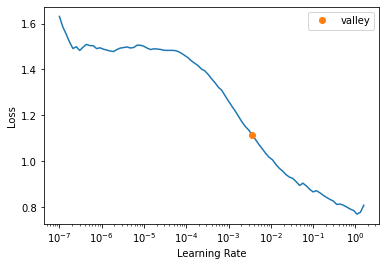

In [ ]:
news_classifier.lr_find()

In [ ]:
news_classifier.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.378631,0.303507,0.893125,02:35
1,0.354643,0.301174,0.896167,02:34
2,0.348108,0.280948,0.899125,02:33
3,0.315258,0.272713,0.904333,02:33
4,0.316156,0.271127,0.904083,02:35


In [ ]:
news_classifier.predict('India are the cricket world champions!') #2 belongs to sports category

('2', tensor(1), tensor([1.1558e-02, 9.8570e-01, 9.3228e-04, 1.8126e-03]))